In [3]:
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import time
import torch.nn
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2

LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN = "/kaggle/working/saved-model/gen.pth"
CHECKPOINT_DISC = "/kaggle/working/saved-model/disc.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-5
NUM_EPOCHS = 250
BATCH_SIZE = 16
LAMBDA_GP = 10
NUM_WORKERS = 4
HIGH_RES = 128
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3

highres_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

both_transforms = A.Compose(
    [
        A.RandomCrop(width=HIGH_RES, height=HIGH_RES),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)


In [2]:
from pathlib import Path
Path('/kaggle/working/saved-model').mkdir(parents=True, exist_ok=True)


In [3]:

class MyImageFolder(Dataset):
    def __init__(self, root_dir):
        super(MyImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index] * len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])

        image = cv2.imread(os.path.join(root_and_dir, img_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        both_transform = both_transforms(image=image)["image"]
        low_res = lowres_transform(image=both_transform)["image"]
        high_res = highres_transform(image=both_transform)["image"]
        return low_res, high_res


def test():
    dataset = MyImageFolder(root_dir="/kaggle/input/div2k-dataset/DIV2K_train_HR")
    loader = DataLoader(dataset, batch_size=8)

    for low_res, high_res in loader:
        print(low_res.shape)
        print(high_res.shape)


#if __name__ == "__main__":
    #test()


In [4]:
from torchvision.models import vgg19
import torch.nn as nn


class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(DEVICE)

        for param in self.vgg.parameters():
            param.requires_grad = False

        self.loss = nn.MSELoss()

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)


In [5]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True,
                ),
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

def initialize_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale

        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale


def test():
    gen = Generator()
    disc = Discriminator()
    low_res = 24
    x = torch.randn((5, 3, low_res, low_res))
    gen_out = gen(x)
    disc_out = disc(gen_out)

    print(gen_out.shape)
    print(disc_out.shape)

#if __name__ == "__main__":
#   test()


In [6]:
from torchvision.utils import save_image


def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="/kaggle/working/saved-model/gen.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    # model.load_state_dict(checkpoint)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:
        image=Image.open(os.path.join("/kaggle/input/test-images/", file))
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img, "/kaggle/output/")
    gen.train()


In [7]:

from torch import optim
from torch.utils.tensorboard import SummaryWriter

torch.backends.cudnn.benchmark = True

def train_fn(
    loader,
    disc,
    gen,
    opt_gen,
    opt_disc,
    l1,
    vgg_loss,
    g_scaler,
    d_scaler,
    writer,
    tb_step,
):
    loop = tqdm(loader, leave=True)

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(low_res)
            critic_real = disc(high_res)
            critic_fake = disc(fake.detach())
            gp = gradient_penalty(disc, high_res, fake, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
            )

        opt_disc.zero_grad()
        d_scaler.scale(loss_critic).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        with torch.cuda.amp.autocast():
            l1_loss = 1e-2 * l1(fake, high_res)
            adversarial_loss = 5e-3 * -torch.mean(disc(fake))
            loss_for_vgg = vgg_loss(fake, high_res)
            gen_loss = l1_loss + loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        writer.add_scalar("Critic loss", loss_critic.item(), global_step=tb_step)
        tb_step += 1

        if idx % 100 == 0 and idx > 0:
            plot_examples("test_images/", gen)

        loop.set_postfix(
            gp=gp.item(),
            critic=loss_critic.item(),
            l1=l1_loss.item(),
            vgg=loss_for_vgg.item(),
            adversarial=adversarial_loss.item(),
        )

    return tb_step


def main():
    dataset = MyImageFolder(root_dir="/kaggle/input/div2k-dataset/DIV2K_train_HR")
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    gen = Generator(in_channels=3).to(DEVICE)
    disc = Discriminator(in_channels=3).to(DEVICE)
    initialize_weights(gen)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
    writer = SummaryWriter("logs")
    tb_step = 0
    l1 = nn.L1Loss()
    gen.train()
    disc.train()
    vgg_loss = VGGLoss()

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
    save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

  


    for epoch in range(NUM_EPOCHS):
        print("Running :",epoch+1,"/",NUM_EPOCHS)
        tb_step = train_fn(
            loader,
            disc,
            gen,
            opt_gen,
            opt_disc,
            l1,
            vgg_loss,
            g_scaler,
            d_scaler,
            writer,
            tb_step,
        )

        if SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename="/kaggle/working/saved-model/gen.pth")
            save_checkpoint(disc, opt_disc, filename="/kaggle/working/saved-model/disc.pth")


if __name__ == "__main__":
    try_model = False

    if try_model:
        # Will just use pretrained weights and run on images
        # in test_images/ and save the ones to SR in saved/
        gen = Generator(in_channels=3).to(DEVICE)
        opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
        load_checkpoint(
            CHECKPOINT_GEN,
            gen,
            opt_gen,
            LEARNING_RATE,
        )
        plot_examples("/kaggle/working/test-images", gen)
    else:
        # This will train from scratch
        main()


2024-05-04 11:30:17.912147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 11:30:17.912291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 11:30:18.035065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights'

=> Saving checkpoint
=> Saving checkpoint
Running : 1 / 250


100%|██████████| 50/50 [00:49<00:00,  1.00it/s, adversarial=-.148, critic=41.8, gp=0.786, l1=0.017, vgg=4.75]      


=> Saving checkpoint
=> Saving checkpoint
Running : 2 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.0481, critic=14.6, gp=0.794, l1=0.00372, vgg=2.62]  


=> Saving checkpoint
=> Saving checkpoint
Running : 3 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=0.115, critic=14, gp=0.624, l1=0.0039, vgg=3.89]      


=> Saving checkpoint
=> Saving checkpoint
Running : 4 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.189, critic=5.24, gp=0.246, l1=0.00284, vgg=3.2]  


=> Saving checkpoint
=> Saving checkpoint
Running : 5 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.261, critic=5.61, gp=0.0169, l1=0.00302, vgg=3.41] 


=> Saving checkpoint
=> Saving checkpoint
Running : 6 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=0.15, critic=-6.74, gp=0.0685, l1=0.00241, vgg=3.23] 


=> Saving checkpoint
=> Saving checkpoint
Running : 7 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.222, critic=4.62, gp=0.012, l1=0.00387, vgg=2.63]   


=> Saving checkpoint
=> Saving checkpoint
Running : 8 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.316, critic=1.73, gp=0.00403, l1=0.00304, vgg=2.88] 


=> Saving checkpoint
=> Saving checkpoint
Running : 9 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.0814, critic=19.3, gp=0.11, l1=0.00445, vgg=2.74]   


=> Saving checkpoint
=> Saving checkpoint
Running : 10 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=0.197, critic=-8.39, gp=0.0449, l1=0.00301, vgg=3.68]


=> Saving checkpoint
=> Saving checkpoint
Running : 11 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=-.659, critic=133, gp=1.14, l1=0.00476, vgg=3.47]    


=> Saving checkpoint
=> Saving checkpoint
Running : 12 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.573, critic=-22, gp=0.389, l1=0.00341, vgg=1.83]   


=> Saving checkpoint
=> Saving checkpoint
Running : 13 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=0.354, critic=10.8, gp=0.228, l1=0.00377, vgg=6.94] 


=> Saving checkpoint
=> Saving checkpoint
Running : 14 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=0.539, critic=-17.2, gp=0.0889, l1=0.00259, vgg=2.58]


=> Saving checkpoint
=> Saving checkpoint
Running : 15 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=0.382, critic=-9.32, gp=0.0771, l1=0.00278, vgg=3.27]


=> Saving checkpoint
=> Saving checkpoint
Running : 16 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=-.0484, critic=1.86, gp=0.384, l1=0.00209, vgg=2.99]  


=> Saving checkpoint
=> Saving checkpoint
Running : 17 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=0.616, critic=4.54, gp=0.504, l1=0.00314, vgg=4.29]  


=> Saving checkpoint
=> Saving checkpoint
Running : 18 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=-.0671, critic=-66.2, gp=0.105, l1=0.00376, vgg=2.79] 


=> Saving checkpoint
=> Saving checkpoint
Running : 19 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.412, critic=31.6, gp=1.49, l1=0.00298, vgg=1.75]   


=> Saving checkpoint
=> Saving checkpoint
Running : 20 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=0.206, critic=-15.9, gp=0.143, l1=0.00275, vgg=2.99] 


=> Saving checkpoint
=> Saving checkpoint
Running : 21 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=1.06, critic=-35.7, gp=0.494, l1=0.00218, vgg=2.13]  


=> Saving checkpoint
=> Saving checkpoint
Running : 22 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.895, critic=-36.6, gp=0.574, l1=0.00191, vgg=2.26] 


=> Saving checkpoint
=> Saving checkpoint
Running : 23 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=0.637, critic=-8.92, gp=0.058, l1=0.00222, vgg=2.81] 


=> Saving checkpoint
=> Saving checkpoint
Running : 24 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=0.276, critic=-26.9, gp=0.105, l1=0.00254, vgg=2.26]  


=> Saving checkpoint
=> Saving checkpoint
Running : 25 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.194, critic=4.22, gp=0.191, l1=0.00203, vgg=1.92]  


=> Saving checkpoint
=> Saving checkpoint
Running : 26 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.369, critic=37.7, gp=0.0721, l1=0.00303, vgg=3.28] 


=> Saving checkpoint
=> Saving checkpoint
Running : 27 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.205, critic=5.49, gp=0.374, l1=0.0022, vgg=2.78]    


=> Saving checkpoint
=> Saving checkpoint
Running : 28 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=-.0859, critic=-2.15, gp=0.0305, l1=0.00262, vgg=1.88] 


=> Saving checkpoint
=> Saving checkpoint
Running : 29 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.452, critic=-23.1, gp=0.323, l1=0.00184, vgg=3.7]   


=> Saving checkpoint
=> Saving checkpoint
Running : 30 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=0.0507, critic=-21.7, gp=0.0281, l1=0.00355, vgg=3.73]


=> Saving checkpoint
=> Saving checkpoint
Running : 31 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.819, critic=-14, gp=0.0526, l1=0.00206, vgg=3.07]   


=> Saving checkpoint
=> Saving checkpoint
Running : 32 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=1.14, critic=-17.4, gp=0.195, l1=0.00226, vgg=2.2]    


=> Saving checkpoint
=> Saving checkpoint
Running : 33 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.0171, critic=-18.3, gp=0.0514, l1=0.00265, vgg=2.4]


=> Saving checkpoint
=> Saving checkpoint
Running : 34 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=1.52, critic=-26.2, gp=0.263, l1=0.0024, vgg=3.25]    


=> Saving checkpoint
=> Saving checkpoint
Running : 35 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.658, critic=19.2, gp=0.0593, l1=0.00317, vgg=1.92] 


=> Saving checkpoint
=> Saving checkpoint
Running : 36 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.506, critic=118, gp=0.06, l1=0.013, vgg=3.7]      


=> Saving checkpoint
=> Saving checkpoint
Running : 37 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.275, critic=-16.2, gp=4.66, l1=0.00248, vgg=3.14]  


=> Saving checkpoint
=> Saving checkpoint
Running : 38 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=1.42, critic=-10.7, gp=0.00954, l1=0.00193, vgg=4.06]


=> Saving checkpoint
=> Saving checkpoint
Running : 39 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.52, critic=5.75, gp=0.413, l1=0.00248, vgg=3.62]   


=> Saving checkpoint
=> Saving checkpoint
Running : 40 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.583, critic=43.3, gp=1.32, l1=0.00267, vgg=3.65]   


=> Saving checkpoint
=> Saving checkpoint
Running : 41 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=1.4, critic=-19.4, gp=0.0628, l1=0.00236, vgg=2.4]   


=> Saving checkpoint
=> Saving checkpoint
Running : 42 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.449, critic=-59, gp=0.0848, l1=0.00302, vgg=3.08]  


=> Saving checkpoint
=> Saving checkpoint
Running : 43 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.499, critic=-136, gp=1.77, l1=0.00321, vgg=3.06]  


=> Saving checkpoint
=> Saving checkpoint
Running : 44 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=1.13, critic=-11.8, gp=0.0704, l1=0.00279, vgg=2.58]


=> Saving checkpoint
=> Saving checkpoint
Running : 45 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=1.2, critic=-24.9, gp=0.131, l1=0.00211, vgg=4.62]   


=> Saving checkpoint
=> Saving checkpoint
Running : 46 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.435, critic=9.54, gp=0.273, l1=0.00301, vgg=2.05]  


=> Saving checkpoint
=> Saving checkpoint
Running : 47 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.983, critic=8.76, gp=0.0511, l1=0.00283, vgg=3.06] 


=> Saving checkpoint
=> Saving checkpoint
Running : 48 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.604, critic=-65.8, gp=10.4, l1=0.0025, vgg=2.06]  


=> Saving checkpoint
=> Saving checkpoint
Running : 49 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.932, critic=-21.5, gp=0.515, l1=0.00264, vgg=2.33]


=> Saving checkpoint
=> Saving checkpoint
Running : 50 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=1.48, critic=-10.8, gp=1.04, l1=0.00222, vgg=3.17]  


=> Saving checkpoint
=> Saving checkpoint
Running : 51 / 250


100%|██████████| 50/50 [00:38<00:00,  1.32it/s, adversarial=0.551, critic=-6.04, gp=0.834, l1=0.00251, vgg=2.95] 


=> Saving checkpoint
=> Saving checkpoint
Running : 52 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=1.22, critic=-13.2, gp=1.16, l1=0.00219, vgg=2.94]  


=> Saving checkpoint
=> Saving checkpoint
Running : 53 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=1.62, critic=-59, gp=1.1, l1=0.0023, vgg=2.97]       


=> Saving checkpoint
=> Saving checkpoint
Running : 54 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.26, critic=-33.1, gp=0.0333, l1=0.00424, vgg=2.1]  


=> Saving checkpoint
=> Saving checkpoint
Running : 55 / 250


100%|██████████| 50/50 [00:37<00:00,  1.35it/s, adversarial=2.27, critic=-47.3, gp=0.666, l1=0.00219, vgg=2.45]   


=> Saving checkpoint
=> Saving checkpoint
Running : 56 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.808, critic=-64.9, gp=0.542, l1=0.00307, vgg=2.18]


=> Saving checkpoint
=> Saving checkpoint
Running : 57 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=1.5, critic=-34.7, gp=0.985, l1=0.00228, vgg=2.69]  


=> Saving checkpoint
=> Saving checkpoint
Running : 58 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=1.25, critic=74.8, gp=0.451, l1=0.00592, vgg=2.44]  


=> Saving checkpoint
=> Saving checkpoint
Running : 59 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.667, critic=-14.3, gp=0.43, l1=0.00346, vgg=2.66] 


=> Saving checkpoint
=> Saving checkpoint
Running : 60 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=1.27, critic=-49.5, gp=0.534, l1=0.00255, vgg=1.44] 


=> Saving checkpoint
=> Saving checkpoint
Running : 61 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=1.17, critic=-6.62, gp=1.49, l1=0.00256, vgg=4.47]   


=> Saving checkpoint
=> Saving checkpoint
Running : 62 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=1.28, critic=-4.89, gp=0.311, l1=0.00494, vgg=2.82] 


=> Saving checkpoint
=> Saving checkpoint
Running : 63 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.108, critic=110, gp=3.87, l1=0.00253, vgg=2.9]    


=> Saving checkpoint
=> Saving checkpoint
Running : 64 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=0.918, critic=102, gp=1.89, l1=0.00382, vgg=2.24]   


=> Saving checkpoint
=> Saving checkpoint
Running : 65 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.855, critic=50.7, gp=0.25, l1=0.00483, vgg=3.2]   


=> Saving checkpoint
=> Saving checkpoint
Running : 66 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=1.41, critic=-49.5, gp=0.761, l1=0.00227, vgg=2.45] 


=> Saving checkpoint
=> Saving checkpoint
Running : 67 / 250


100%|██████████| 50/50 [00:37<00:00,  1.35it/s, adversarial=0.836, critic=-27.6, gp=0.645, l1=0.00212, vgg=2.97]


=> Saving checkpoint
=> Saving checkpoint
Running : 68 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.964, critic=7.78, gp=0.281, l1=0.00325, vgg=2.43] 


=> Saving checkpoint
=> Saving checkpoint
Running : 69 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=0.875, critic=-19.6, gp=0.59, l1=0.00127, vgg=2.26] 


=> Saving checkpoint
=> Saving checkpoint
Running : 70 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.905, critic=-26.7, gp=0.762, l1=0.00138, vgg=2.87]


=> Saving checkpoint
=> Saving checkpoint
Running : 71 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=0.582, critic=-24.6, gp=0.621, l1=0.0014, vgg=2.06] 


=> Saving checkpoint
=> Saving checkpoint
Running : 72 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.817, critic=-28.1, gp=0.829, l1=0.00147, vgg=2.66]


=> Saving checkpoint
=> Saving checkpoint
Running : 73 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.588, critic=-32.1, gp=0.945, l1=0.00176, vgg=4.08]


=> Saving checkpoint
=> Saving checkpoint
Running : 74 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.61, critic=-27.4, gp=0.459, l1=0.00159, vgg=2.35] 


=> Saving checkpoint
=> Saving checkpoint
Running : 75 / 250


100%|██████████| 50/50 [00:37<00:00,  1.35it/s, adversarial=0.423, critic=-18.8, gp=0.529, l1=0.00147, vgg=2.71]


=> Saving checkpoint
=> Saving checkpoint
Running : 76 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.649, critic=-27.9, gp=0.976, l1=0.00153, vgg=2.89]


=> Saving checkpoint
=> Saving checkpoint
Running : 77 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.525, critic=-32, gp=0.743, l1=0.00149, vgg=3.34]   


=> Saving checkpoint
=> Saving checkpoint
Running : 78 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=0.576, critic=-23.4, gp=1.03, l1=0.00133, vgg=3.46] 


=> Saving checkpoint
=> Saving checkpoint
Running : 79 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.366, critic=-13.4, gp=0.815, l1=0.00146, vgg=3.16]


=> Saving checkpoint
=> Saving checkpoint
Running : 80 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.423, critic=-23, gp=0.557, l1=0.0013, vgg=3.34]   


=> Saving checkpoint
=> Saving checkpoint
Running : 81 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.466, critic=-25.1, gp=0.799, l1=0.00138, vgg=2.37]


=> Saving checkpoint
=> Saving checkpoint
Running : 82 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=0.416, critic=-28.7, gp=0.662, l1=0.00141, vgg=2.27]


=> Saving checkpoint
=> Saving checkpoint
Running : 83 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.461, critic=-28.2, gp=1.29, l1=0.0013, vgg=4.63]  


=> Saving checkpoint
=> Saving checkpoint
Running : 84 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.497, critic=-27.1, gp=0.734, l1=0.00128, vgg=3.7] 


=> Saving checkpoint
=> Saving checkpoint
Running : 85 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.591, critic=-20.1, gp=0.706, l1=0.00127, vgg=2.26]


=> Saving checkpoint
=> Saving checkpoint
Running : 86 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=0.413, critic=-22.8, gp=0.677, l1=0.00138, vgg=3.22]


=> Saving checkpoint
=> Saving checkpoint
Running : 87 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=0.417, critic=-22.8, gp=0.691, l1=0.00123, vgg=2.72]


=> Saving checkpoint
=> Saving checkpoint
Running : 88 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.364, critic=-26.8, gp=0.851, l1=0.0012, vgg=3.37] 


=> Saving checkpoint
=> Saving checkpoint
Running : 89 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.358, critic=-35.6, gp=1.89, l1=0.00138, vgg=2.4]   


=> Saving checkpoint
=> Saving checkpoint
Running : 90 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.296, critic=-28, gp=0.896, l1=0.00128, vgg=2.62]   


=> Saving checkpoint
=> Saving checkpoint
Running : 91 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=0.177, critic=-30.9, gp=0.894, l1=0.00143, vgg=3.28] 


=> Saving checkpoint
=> Saving checkpoint
Running : 92 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.449, critic=-22.6, gp=0.681, l1=0.00102, vgg=2.35] 


=> Saving checkpoint
=> Saving checkpoint
Running : 93 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.227, critic=-21.7, gp=0.592, l1=0.00114, vgg=2.81]


=> Saving checkpoint
=> Saving checkpoint
Running : 94 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.23, critic=-21, gp=1.36, l1=0.00103, vgg=2.14]     


=> Saving checkpoint
=> Saving checkpoint
Running : 95 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.182, critic=-24, gp=0.73, l1=0.0013, vgg=3.03]     


=> Saving checkpoint
=> Saving checkpoint
Running : 96 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.173, critic=-16.9, gp=1.14, l1=0.000925, vgg=2.42] 


=> Saving checkpoint
=> Saving checkpoint
Running : 97 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.17, critic=-21.7, gp=0.397, l1=0.00101, vgg=2.71]  


=> Saving checkpoint
=> Saving checkpoint
Running : 98 / 250


100%|██████████| 50/50 [00:41<00:00,  1.22it/s, adversarial=0.116, critic=-21.9, gp=1.05, l1=0.00103, vgg=1.86]    


=> Saving checkpoint
=> Saving checkpoint
Running : 99 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=0.144, critic=-14.2, gp=0.989, l1=0.000901, vgg=2.28]


=> Saving checkpoint
=> Saving checkpoint
Running : 100 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.211, critic=-24.8, gp=0.457, l1=0.00108, vgg=1.95]  


=> Saving checkpoint
=> Saving checkpoint
Running : 101 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.164, critic=-37, gp=0.807, l1=0.00138, vgg=3.34]     


=> Saving checkpoint
=> Saving checkpoint
Running : 102 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.102, critic=-31.8, gp=0.533, l1=0.00109, vgg=1.55] 


=> Saving checkpoint
=> Saving checkpoint
Running : 103 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.17, critic=-27.3, gp=0.545, l1=0.00114, vgg=2.91]    


=> Saving checkpoint
=> Saving checkpoint
Running : 104 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.0512, critic=-26.3, gp=1.01, l1=0.0013, vgg=2.55]   


=> Saving checkpoint
=> Saving checkpoint
Running : 105 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=0.0891, critic=-14.2, gp=0.415, l1=0.000818, vgg=1.66]


=> Saving checkpoint
=> Saving checkpoint
Running : 106 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.115, critic=-23.5, gp=1.25, l1=0.00102, vgg=1.85]   


=> Saving checkpoint
=> Saving checkpoint
Running : 107 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=0.00363, critic=-30.4, gp=0.792, l1=0.00118, vgg=2.4] 


=> Saving checkpoint
=> Saving checkpoint
Running : 108 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.178, critic=-8.87, gp=0.575, l1=0.0011, vgg=1.55]   


=> Saving checkpoint
=> Saving checkpoint
Running : 109 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=0.335, critic=-26.8, gp=0.498, l1=0.000961, vgg=1.33]  


=> Saving checkpoint
=> Saving checkpoint
Running : 110 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.167, critic=-22.8, gp=0.619, l1=0.000996, vgg=2.14] 


=> Saving checkpoint
=> Saving checkpoint
Running : 111 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.0984, critic=-23.7, gp=0.495, l1=0.000956, vgg=2.45]


=> Saving checkpoint
=> Saving checkpoint
Running : 112 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=0.134, critic=3.57, gp=1.92, l1=0.00111, vgg=1.18]     


=> Saving checkpoint
=> Saving checkpoint
Running : 113 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=0.0817, critic=-23.7, gp=0.761, l1=0.00107, vgg=1.79] 


=> Saving checkpoint
=> Saving checkpoint
Running : 114 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=0.0394, critic=-24.6, gp=1.14, l1=0.00108, vgg=2.16]  


=> Saving checkpoint
=> Saving checkpoint
Running : 115 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=0.0072, critic=-17.5, gp=1.11, l1=0.000952, vgg=2.4]   


=> Saving checkpoint
=> Saving checkpoint
Running : 116 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.0717, critic=-28.6, gp=0.949, l1=0.00108, vgg=2.23]  


=> Saving checkpoint
=> Saving checkpoint
Running : 117 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=-.0735, critic=-26.6, gp=0.907, l1=0.000973, vgg=2.01] 


=> Saving checkpoint
=> Saving checkpoint
Running : 118 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=0.025, critic=-22.6, gp=0.569, l1=0.000926, vgg=2.53] 


=> Saving checkpoint
=> Saving checkpoint
Running : 119 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.00614, critic=-22.3, gp=0.306, l1=0.00106, vgg=2.43] 


=> Saving checkpoint
=> Saving checkpoint
Running : 120 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0142, critic=-23.8, gp=0.27, l1=0.000918, vgg=1.97]  


=> Saving checkpoint
=> Saving checkpoint
Running : 121 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.0534, critic=-18.7, gp=0.768, l1=0.000817, vgg=1.76]


=> Saving checkpoint
=> Saving checkpoint
Running : 122 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.00959, critic=-28.7, gp=0.884, l1=0.00104, vgg=1.62] 


=> Saving checkpoint
=> Saving checkpoint
Running : 123 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0638, critic=-28, gp=0.778, l1=0.00106, vgg=2.2]     


=> Saving checkpoint
=> Saving checkpoint
Running : 124 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=0.114, critic=-18.2, gp=0.492, l1=0.000816, vgg=1.58]  


=> Saving checkpoint
=> Saving checkpoint
Running : 125 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.439, critic=-25.6, gp=0.282, l1=0.00116, vgg=1.89]  


=> Saving checkpoint
=> Saving checkpoint
Running : 126 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0197, critic=-25.7, gp=0.736, l1=0.00104, vgg=1.85]  


=> Saving checkpoint
=> Saving checkpoint
Running : 127 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.0258, critic=-19.8, gp=0.445, l1=0.000927, vgg=1.82]


=> Saving checkpoint
=> Saving checkpoint
Running : 128 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.142, critic=-14.3, gp=0.563, l1=0.000835, vgg=1.19]  


=> Saving checkpoint
=> Saving checkpoint
Running : 129 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.128, critic=-15.3, gp=0.478, l1=0.000839, vgg=1.28]  


=> Saving checkpoint
=> Saving checkpoint
Running : 130 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0831, critic=-27.5, gp=0.553, l1=0.00116, vgg=1.97]  


=> Saving checkpoint
=> Saving checkpoint
Running : 131 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0664, critic=-22.8, gp=0.269, l1=0.00104, vgg=2.62]  


=> Saving checkpoint
=> Saving checkpoint
Running : 132 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.000211, critic=-24.7, gp=0.612, l1=0.00105, vgg=2.98]


=> Saving checkpoint
=> Saving checkpoint
Running : 133 / 250


100%|██████████| 50/50 [00:38<00:00,  1.32it/s, adversarial=0.0312, critic=-14.9, gp=1.21, l1=0.000891, vgg=2.02] 


=> Saving checkpoint
=> Saving checkpoint
Running : 134 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.125, critic=-26.6, gp=0.576, l1=0.00106, vgg=2]      


=> Saving checkpoint
=> Saving checkpoint
Running : 135 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0124, critic=-17, gp=0.462, l1=0.000869, vgg=1.28]   


=> Saving checkpoint
=> Saving checkpoint
Running : 136 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.195, critic=-32, gp=1.05, l1=0.00107, vgg=1.83]      


=> Saving checkpoint
=> Saving checkpoint
Running : 137 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.144, critic=-18.1, gp=0.445, l1=0.000948, vgg=1.44]  


=> Saving checkpoint
=> Saving checkpoint
Running : 138 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.0411, critic=-20.1, gp=0.54, l1=0.00092, vgg=2.52]   


=> Saving checkpoint
=> Saving checkpoint
Running : 139 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.115, critic=-18.5, gp=0.305, l1=0.000896, vgg=1.69]  


=> Saving checkpoint
=> Saving checkpoint
Running : 140 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=-.136, critic=-25.8, gp=0.717, l1=0.000961, vgg=1.37]   


=> Saving checkpoint
=> Saving checkpoint
Running : 141 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.0542, critic=-18, gp=0.419, l1=0.000873, vgg=1.99]   


=> Saving checkpoint
=> Saving checkpoint
Running : 142 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.0812, critic=-15.4, gp=0.725, l1=0.000812, vgg=1.44] 


=> Saving checkpoint
=> Saving checkpoint
Running : 143 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.0887, critic=-13.5, gp=0.337, l1=0.000806, vgg=1.27] 


=> Saving checkpoint
=> Saving checkpoint
Running : 144 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.0718, critic=-15.4, gp=0.427, l1=0.000749, vgg=1.67] 


=> Saving checkpoint
=> Saving checkpoint
Running : 145 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.102, critic=-14.4, gp=0.639, l1=0.000926, vgg=1.57]  


=> Saving checkpoint
=> Saving checkpoint
Running : 146 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0765, critic=-20.8, gp=0.568, l1=0.000818, vgg=1.49] 


=> Saving checkpoint
=> Saving checkpoint
Running : 147 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.00047, critic=-26.4, gp=0.635, l1=0.001, vgg=1.69]   


=> Saving checkpoint
=> Saving checkpoint
Running : 148 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0427, critic=-20.4, gp=0.582, l1=0.000905, vgg=1.73] 


=> Saving checkpoint
=> Saving checkpoint
Running : 149 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.117, critic=-20.6, gp=0.653, l1=0.000945, vgg=1.69] 


=> Saving checkpoint
=> Saving checkpoint
Running : 150 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0269, critic=-18.8, gp=0.682, l1=0.000809, vgg=1.95]  


=> Saving checkpoint
=> Saving checkpoint
Running : 151 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=0.115, critic=-16.3, gp=0.578, l1=0.000697, vgg=0.979]  


=> Saving checkpoint
=> Saving checkpoint
Running : 152 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=0.0667, critic=-16.1, gp=1.58, l1=0.000851, vgg=1.4]   


=> Saving checkpoint
=> Saving checkpoint
Running : 153 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.05, critic=-16.9, gp=0.318, l1=0.000805, vgg=2.39]   


=> Saving checkpoint
=> Saving checkpoint
Running : 154 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.1, critic=-20.9, gp=0.482, l1=0.000832, vgg=1.16]     


=> Saving checkpoint
=> Saving checkpoint
Running : 155 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=-.0063, critic=-12.9, gp=0.462, l1=0.000681, vgg=1.65] 


=> Saving checkpoint
=> Saving checkpoint
Running : 156 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0144, critic=-12.7, gp=0.128, l1=0.000697, vgg=1.73]  


=> Saving checkpoint
=> Saving checkpoint
Running : 157 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=0.035, critic=-14.2, gp=0.293, l1=0.000743, vgg=0.982] 


=> Saving checkpoint
=> Saving checkpoint
Running : 158 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.0862, critic=-14.7, gp=0.555, l1=0.000836, vgg=2]    


=> Saving checkpoint
=> Saving checkpoint
Running : 159 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.116, critic=-10.2, gp=0.21, l1=0.000674, vgg=1.43]   


=> Saving checkpoint
=> Saving checkpoint
Running : 160 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.0507, critic=-10.8, gp=0.11, l1=0.000619, vgg=2.13]  


=> Saving checkpoint
=> Saving checkpoint
Running : 161 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.114, critic=-12.7, gp=0.212, l1=0.000625, vgg=1.96]  


=> Saving checkpoint
=> Saving checkpoint
Running : 162 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=0.0384, critic=-14.7, gp=0.191, l1=0.000739, vgg=1.89] 


=> Saving checkpoint
=> Saving checkpoint
Running : 163 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.0147, critic=-13.5, gp=0.208, l1=0.000739, vgg=1.22]


=> Saving checkpoint
=> Saving checkpoint
Running : 164 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.0985, critic=-10.8, gp=0.509, l1=0.000699, vgg=1.92] 


=> Saving checkpoint
=> Saving checkpoint
Running : 165 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.00496, critic=-11.4, gp=0.165, l1=0.000598, vgg=1.86] 


=> Saving checkpoint
=> Saving checkpoint
Running : 166 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.18, critic=-18.4, gp=0.47, l1=0.000898, vgg=1.47]    


=> Saving checkpoint
=> Saving checkpoint
Running : 167 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.00741, critic=-11.6, gp=0.224, l1=0.000553, vgg=1.43]


=> Saving checkpoint
=> Saving checkpoint
Running : 168 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.143, critic=-17.9, gp=0.271, l1=0.000838, vgg=2]       


=> Saving checkpoint
=> Saving checkpoint
Running : 169 / 250


100%|██████████| 50/50 [00:37<00:00,  1.35it/s, adversarial=-.0246, critic=-11.2, gp=0.17, l1=0.000628, vgg=1.78]  


=> Saving checkpoint
=> Saving checkpoint
Running : 170 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=0.0215, critic=-13.1, gp=0.244, l1=0.000574, vgg=1.36]  


=> Saving checkpoint
=> Saving checkpoint
Running : 171 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=0.0254, critic=-10, gp=0.257, l1=0.000738, vgg=2.15]   


=> Saving checkpoint
=> Saving checkpoint
Running : 172 / 250


100%|██████████| 50/50 [00:38<00:00,  1.32it/s, adversarial=-.00961, critic=-11.6, gp=0.211, l1=0.000668, vgg=1.84]


=> Saving checkpoint
=> Saving checkpoint
Running : 173 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.00678, critic=-11.9, gp=0.475, l1=0.000644, vgg=1.52] 


=> Saving checkpoint
=> Saving checkpoint
Running : 174 / 250


100%|██████████| 50/50 [00:37<00:00,  1.35it/s, adversarial=0.0616, critic=-10.6, gp=0.249, l1=0.00065, vgg=1.27]  


=> Saving checkpoint
=> Saving checkpoint
Running : 175 / 250


100%|██████████| 50/50 [00:36<00:00,  1.35it/s, adversarial=-.009, critic=-6.67, gp=0.157, l1=0.000589, vgg=1.03]  


=> Saving checkpoint
=> Saving checkpoint
Running : 176 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.0116, critic=-13.8, gp=0.171, l1=0.000681, vgg=1.55] 


=> Saving checkpoint
=> Saving checkpoint
Running : 177 / 250


100%|██████████| 50/50 [00:36<00:00,  1.36it/s, adversarial=-.0172, critic=-15.9, gp=0.224, l1=0.000683, vgg=2.23] 


=> Saving checkpoint
=> Saving checkpoint
Running : 178 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.00748, critic=-10.6, gp=0.138, l1=0.000554, vgg=1.29]


=> Saving checkpoint
=> Saving checkpoint
Running : 179 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0172, critic=-8.73, gp=0.222, l1=0.000575, vgg=1.35] 


=> Saving checkpoint
=> Saving checkpoint
Running : 180 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=0.0447, critic=-8.93, gp=0.384, l1=0.000542, vgg=2.07]  


=> Saving checkpoint
=> Saving checkpoint
Running : 181 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.103, critic=-13.5, gp=0.314, l1=0.000646, vgg=1.5]   


=> Saving checkpoint
=> Saving checkpoint
Running : 182 / 250


100%|██████████| 50/50 [00:38<00:00,  1.31it/s, adversarial=-.00324, critic=-11.5, gp=0.229, l1=0.000646, vgg=2.12] 


=> Saving checkpoint
=> Saving checkpoint
Running : 183 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0743, critic=-12.6, gp=0.327, l1=0.000688, vgg=2.03]  


=> Saving checkpoint
=> Saving checkpoint
Running : 184 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=-.0748, critic=-14.5, gp=0.239, l1=0.000659, vgg=1.58]  


=> Saving checkpoint
=> Saving checkpoint
Running : 185 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.0999, critic=-10.1, gp=0.419, l1=0.000607, vgg=1.32] 


=> Saving checkpoint
=> Saving checkpoint
Running : 186 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=-.00243, critic=-8.15, gp=0.172, l1=0.000642, vgg=1.23] 


=> Saving checkpoint
=> Saving checkpoint
Running : 187 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=0.00661, critic=-11.8, gp=0.381, l1=0.000582, vgg=1.06] 


=> Saving checkpoint
=> Saving checkpoint
Running : 188 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.0865, critic=-10.3, gp=0.205, l1=0.000697, vgg=1.26] 


=> Saving checkpoint
=> Saving checkpoint
Running : 189 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0697, critic=-14, gp=0.204, l1=0.000659, vgg=1.52]   


=> Saving checkpoint
=> Saving checkpoint
Running : 190 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0528, critic=-16.3, gp=0.378, l1=0.000841, vgg=1.54]   


=> Saving checkpoint
=> Saving checkpoint
Running : 191 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=-.053, critic=-13, gp=0.322, l1=0.000641, vgg=1.44]     


=> Saving checkpoint
=> Saving checkpoint
Running : 192 / 250


100%|██████████| 50/50 [00:37<00:00,  1.35it/s, adversarial=-.00106, critic=-15.9, gp=0.28, l1=0.000712, vgg=1.34] 


=> Saving checkpoint
=> Saving checkpoint
Running : 193 / 250


100%|██████████| 50/50 [00:37<00:00,  1.34it/s, adversarial=-.129, critic=-17.3, gp=0.435, l1=0.000814, vgg=1.62]  


=> Saving checkpoint
=> Saving checkpoint
Running : 194 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0563, critic=-8.73, gp=0.389, l1=0.000497, vgg=1.09] 


=> Saving checkpoint
=> Saving checkpoint
Running : 195 / 250


100%|██████████| 50/50 [00:36<00:00,  1.35it/s, adversarial=-.0249, critic=-10.4, gp=0.181, l1=0.000705, vgg=1.39] 


=> Saving checkpoint
=> Saving checkpoint
Running : 196 / 250


100%|██████████| 50/50 [00:36<00:00,  1.36it/s, adversarial=-.00645, critic=-8.08, gp=0.465, l1=0.000643, vgg=0.724]


=> Saving checkpoint
=> Saving checkpoint
Running : 197 / 250


100%|██████████| 50/50 [00:38<00:00,  1.30it/s, adversarial=-.0346, critic=-13.5, gp=0.35, l1=0.000662, vgg=2.62]   


=> Saving checkpoint
=> Saving checkpoint
Running : 198 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0213, critic=-12.4, gp=0.223, l1=0.000663, vgg=1.56] 


=> Saving checkpoint
=> Saving checkpoint
Running : 199 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0793, critic=-11.6, gp=0.581, l1=0.00057, vgg=0.736] 


=> Saving checkpoint
=> Saving checkpoint
Running : 200 / 250


100%|██████████| 50/50 [00:37<00:00,  1.33it/s, adversarial=-.0667, critic=-11, gp=0.26, l1=0.000598, vgg=0.842]   


=> Saving checkpoint
=> Saving checkpoint
Running : 201 / 250


100%|██████████| 50/50 [00:36<00:00,  1.35it/s, adversarial=-.0288, critic=-17.3, gp=0.446, l1=0.000679, vgg=1.89] 


=> Saving checkpoint
=> Saving checkpoint
Running : 202 / 250


100%|██████████| 50/50 [00:37<00:00,  1.32it/s, adversarial=-.056, critic=-9.01, gp=0.251, l1=0.000427, vgg=1.22]   


=> Saving checkpoint
=> Saving checkpoint
Running : 203 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=-.0602, critic=-11.7, gp=0.222, l1=0.00065, vgg=2.29]  


=> Saving checkpoint
=> Saving checkpoint
Running : 204 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.159, critic=-21.7, gp=0.371, l1=0.000917, vgg=2.58]  


=> Saving checkpoint
=> Saving checkpoint
Running : 205 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=-.0386, critic=-10.9, gp=0.223, l1=0.000568, vgg=1.03] 


=> Saving checkpoint
=> Saving checkpoint
Running : 206 / 250


100%|██████████| 50/50 [00:38<00:00,  1.29it/s, adversarial=-.0433, critic=-12.3, gp=0.202, l1=0.000726, vgg=1.65] 


=> Saving checkpoint
=> Saving checkpoint
Running : 207 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=-.0551, critic=-9.21, gp=0.336, l1=0.000563, vgg=0.894]


=> Saving checkpoint
=> Saving checkpoint
Running : 208 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0163, critic=-9.54, gp=0.339, l1=0.000585, vgg=1.29] 


=> Saving checkpoint
=> Saving checkpoint
Running : 209 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0865, critic=-10.4, gp=0.222, l1=0.000554, vgg=1.5]   


=> Saving checkpoint
=> Saving checkpoint
Running : 210 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0698, critic=-12.8, gp=0.555, l1=0.000636, vgg=1.34] 


=> Saving checkpoint
=> Saving checkpoint
Running : 211 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0854, critic=-9.57, gp=0.163, l1=0.000548, vgg=1.34] 


=> Saving checkpoint
=> Saving checkpoint
Running : 212 / 250


100%|██████████| 50/50 [00:44<00:00,  1.13it/s, adversarial=-.0621, critic=-13, gp=0.258, l1=0.000634, vgg=1.54]    


=> Saving checkpoint
=> Saving checkpoint
Running : 213 / 250


100%|██████████| 50/50 [00:38<00:00,  1.28it/s, adversarial=-.0899, critic=-15.3, gp=0.21, l1=0.000579, vgg=0.988]  


=> Saving checkpoint
=> Saving checkpoint
Running : 214 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0718, critic=-7, gp=0.274, l1=0.00042, vgg=1.37]      


=> Saving checkpoint
=> Saving checkpoint
Running : 215 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0862, critic=-13.5, gp=0.194, l1=0.00062, vgg=1.24]  


=> Saving checkpoint
=> Saving checkpoint
Running : 216 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=-.0455, critic=-14.7, gp=0.33, l1=0.000751, vgg=1.75]    


=> Saving checkpoint
=> Saving checkpoint
Running : 217 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=-.0426, critic=-8.41, gp=0.361, l1=0.000473, vgg=1.41] 


=> Saving checkpoint
=> Saving checkpoint
Running : 218 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=-.0877, critic=-12.7, gp=0.215, l1=0.000652, vgg=2.15] 


=> Saving checkpoint
=> Saving checkpoint
Running : 219 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.0352, critic=-8.08, gp=0.318, l1=0.000429, vgg=1.15] 


=> Saving checkpoint
=> Saving checkpoint
Running : 220 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.0513, critic=-15, gp=0.246, l1=0.000617, vgg=1.54]   


=> Saving checkpoint
=> Saving checkpoint
Running : 221 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.0103, critic=-8.11, gp=0.347, l1=0.000458, vgg=1.12] 


=> Saving checkpoint
=> Saving checkpoint
Running : 222 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0123, critic=-9.77, gp=0.448, l1=0.000714, vgg=2]    


=> Saving checkpoint
=> Saving checkpoint
Running : 223 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0759, critic=-8.71, gp=0.141, l1=0.000506, vgg=1.05]  


=> Saving checkpoint
=> Saving checkpoint
Running : 224 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=-.0604, critic=-9.18, gp=0.117, l1=0.000494, vgg=1.18]  


=> Saving checkpoint
=> Saving checkpoint
Running : 225 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.0239, critic=-9.91, gp=0.181, l1=0.000637, vgg=1.48] 


=> Saving checkpoint
=> Saving checkpoint
Running : 226 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.031, critic=-12.7, gp=0.692, l1=0.000667, vgg=1.93]  


=> Saving checkpoint
=> Saving checkpoint
Running : 227 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0546, critic=-10.8, gp=0.32, l1=0.00058, vgg=1.35]   


=> Saving checkpoint
=> Saving checkpoint
Running : 228 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.0404, critic=-10, gp=0.255, l1=0.000539, vgg=1.97]   


=> Saving checkpoint
=> Saving checkpoint
Running : 229 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.0316, critic=-7.24, gp=0.282, l1=0.000562, vgg=0.884] 


=> Saving checkpoint
=> Saving checkpoint
Running : 230 / 250


100%|██████████| 50/50 [00:39<00:00,  1.27it/s, adversarial=-.0554, critic=-12, gp=0.252, l1=0.000563, vgg=1.87]    


=> Saving checkpoint
=> Saving checkpoint
Running : 231 / 250


100%|██████████| 50/50 [00:39<00:00,  1.28it/s, adversarial=-.0515, critic=-10.4, gp=0.127, l1=0.00055, vgg=0.982] 


=> Saving checkpoint
=> Saving checkpoint
Running : 232 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0779, critic=-14.5, gp=0.289, l1=0.000684, vgg=1.65] 


=> Saving checkpoint
=> Saving checkpoint
Running : 233 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.00908, critic=-9.69, gp=0.331, l1=0.000615, vgg=0.908]


=> Saving checkpoint
=> Saving checkpoint
Running : 234 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0867, critic=-14.8, gp=0.224, l1=0.000629, vgg=1.49]  


=> Saving checkpoint
=> Saving checkpoint
Running : 235 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0221, critic=-9.84, gp=0.425, l1=0.000509, vgg=1.32] 


=> Saving checkpoint
=> Saving checkpoint
Running : 236 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.0438, critic=-12.8, gp=0.451, l1=0.00085, vgg=1.79]  


=> Saving checkpoint
=> Saving checkpoint
Running : 237 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.0459, critic=-11.7, gp=0.219, l1=0.000652, vgg=1.62] 


=> Saving checkpoint
=> Saving checkpoint
Running : 238 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=-.0609, critic=-10.6, gp=0.317, l1=0.000605, vgg=1.4]  


=> Saving checkpoint
=> Saving checkpoint
Running : 239 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.0513, critic=-11.3, gp=0.206, l1=0.00053, vgg=1.31]  


=> Saving checkpoint
=> Saving checkpoint
Running : 240 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=-.0717, critic=-9.08, gp=0.21, l1=0.000464, vgg=0.933] 


=> Saving checkpoint
=> Saving checkpoint
Running : 241 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=-.0323, critic=-9.18, gp=0.236, l1=0.000489, vgg=1.32] 


=> Saving checkpoint
=> Saving checkpoint
Running : 242 / 250


100%|██████████| 50/50 [00:39<00:00,  1.25it/s, adversarial=-.0591, critic=-12.1, gp=0.312, l1=0.000614, vgg=1.54]  


=> Saving checkpoint
=> Saving checkpoint
Running : 243 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0587, critic=-10.2, gp=0.201, l1=0.000588, vgg=1.21] 


=> Saving checkpoint
=> Saving checkpoint
Running : 244 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.0194, critic=-12.7, gp=0.295, l1=0.000741, vgg=1.23] 


=> Saving checkpoint
=> Saving checkpoint
Running : 245 / 250


100%|██████████| 50/50 [00:40<00:00,  1.25it/s, adversarial=-.0225, critic=-7.96, gp=0.277, l1=0.000425, vgg=0.807] 


=> Saving checkpoint
=> Saving checkpoint
Running : 246 / 250


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, adversarial=-.06, critic=-11.1, gp=0.184, l1=0.000618, vgg=1.25]   


=> Saving checkpoint
=> Saving checkpoint
Running : 247 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=-.0451, critic=-7.86, gp=0.169, l1=0.000513, vgg=1.02]  


=> Saving checkpoint
=> Saving checkpoint
Running : 248 / 250


100%|██████████| 50/50 [00:41<00:00,  1.21it/s, adversarial=-.0238, critic=-9.99, gp=0.339, l1=0.000496, vgg=2.06] 


=> Saving checkpoint
=> Saving checkpoint
Running : 249 / 250


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, adversarial=-.0612, critic=-7.5, gp=0.128, l1=0.000377, vgg=0.657]  


=> Saving checkpoint
=> Saving checkpoint
Running : 250 / 250


100%|██████████| 50/50 [00:39<00:00,  1.26it/s, adversarial=-.031, critic=-9.86, gp=0.282, l1=0.000537, vgg=1.45]  


=> Saving checkpoint
=> Saving checkpoint


In [13]:
gen = Generator(in_channels=3).to(DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
load_checkpoint(
    CHECKPOINT_GEN,
    gen,
    opt_gen,
    LEARNING_RATE,
)
gen.eval()

image=Image.open("/kaggle/input/me228-test1/low quality.jpg")
with torch.no_grad():
    upscaled_img = gen(
        test_transform(image=np.asarray(image))["image"]
        .unsqueeze(0)
        .to(DEVICE)
    )
save_image(upscaled_img, "/kaggle/working/saved-model/img.jpg")
#gen.train()

=> Loading checkpoint


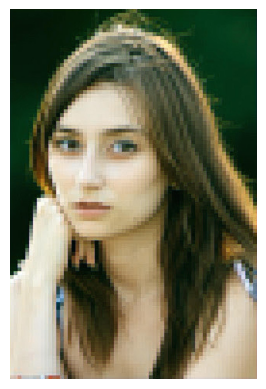

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image using PIL
upscaled_image_path = "/kaggle/working/saved-model/img.jpg"
upscaled_img = Image.open(upscaled_image_path)

# Plot the image
plt.imshow(upscaled_img)
plt.axis('off')
plt.show()


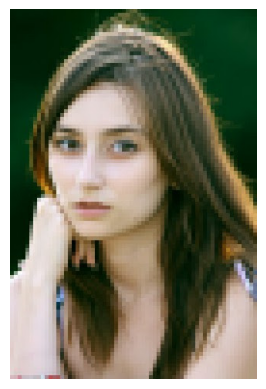

In [15]:
original_image_path = "/kaggle/input/me228-test1/low quality.jpg"
original_img = Image.open(original_image_path)

# Plot the image
plt.imshow(original_img)
plt.axis('off')
plt.show()


#### using the pre trained model on DIV2K dataset and then comparing our results with the output of pre trained model

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from PIL import Image
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'

In [29]:
import requests
url = 'https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgb-j_0Ft67Ovo45DPCETFF9_vosIoqrO8yA19JKUd2_1OUcIzfqxnaoOml6cx3YFGVlEIpPjONt2hMa1yPpdFQHcSyXZyl3fbFVCdlCSqkYnG4lyu6IRyHnHIQsYfnjN_8YhJUZf65zpo/s480/low+quality.jpg'
r = requests.get(url, allow_redirects=True)
open('female-portrait.jpg', 'wb').write(r.content)

IMAGE_PATH = 'female-portrait.jpg'
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [30]:
# function to preprocess image so that it can be handled by model
def preprocess_image(image_path):
   image = tf.image.decode_image(tf.io.read_file(image_path))
   if image.shape[-1] == 4:
     image = image[...,:-1]
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   image = tf.cast(image,tf.float32)
   return tf.expand_dims(image,0)


def save_image(image,filename):
  if not isinstance(image, Image.Image):
      image = tf.clip_by_value(image, 0, 255)
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save('%s.jpg' % filename)
  print('Saved as %s.jpg' % filename)

In [31]:
preprocess_image(IMAGE_PATH)

<tf.Tensor: shape=(1, 480, 320, 3), dtype=float32, numpy=
array([[[[  0.,  28.,   3.],
         [  0.,  28.,   3.],
         [  0.,  28.,   3.],
         ...,
         [  0.,  45.,  14.],
         [  0.,  45.,  14.],
         [  1.,  44.,  14.]],

        [[  0.,  28.,   3.],
         [  0.,  28.,   3.],
         [  0.,  28.,   3.],
         ...,
         [  0.,  45.,  14.],
         [  0.,  45.,  14.],
         [  0.,  45.,  14.]],

        [[  0.,  28.,   3.],
         [  0.,  28.,   3.],
         [  0.,  28.,   3.],
         ...,
         [  0.,  45.,  14.],
         [  0.,  45.,  14.],
         [  0.,  45.,  14.]],

        ...,

        [[214., 185., 190.],
         [212., 183., 188.],
         [214., 183., 189.],
         ...,
         [177., 152., 130.],
         [177., 152., 130.],
         [177., 152., 130.]],

        [[211., 184., 191.],
         [211., 182., 187.],
         [213., 182., 188.],
         ...,
         [177., 152., 130.],
         [177., 152., 130.],
         

In [32]:
def plot_image(image,title=''):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis('off')
  plt.title(title)


loading the model

In [33]:
model = hub.load(SAVED_MODEL_PATH)

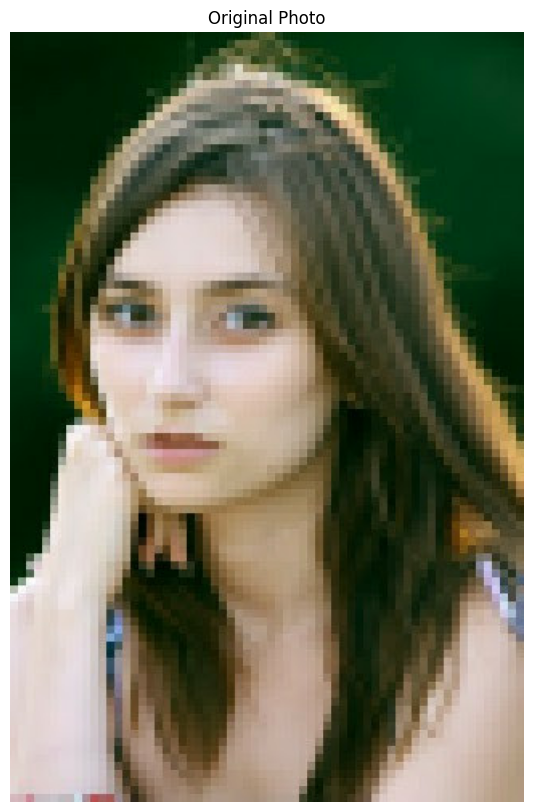

In [34]:
load_image = preprocess_image(IMAGE_PATH)

# plot original image
plot_image(tf.squeeze(load_image),title='Original Photo')

In [35]:
# Start Performing resolution 
start = time.time()
super_image = model(load_image)
super_image = tf.squeeze(super_image)
print('Time taken to complete process: %f'%(time.time() - start))

Time taken to complete process: 1.130123


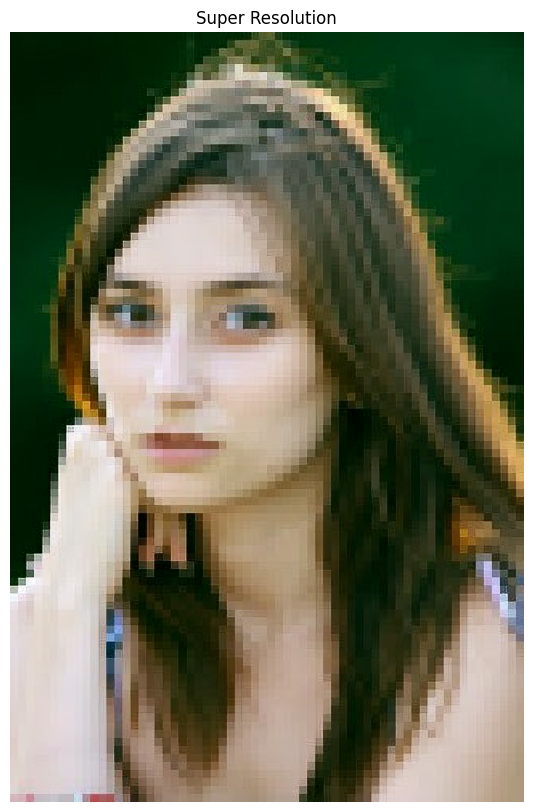

In [36]:
#plot the output image 
plot_image(tf.squeeze(super_image),'Super Resolution')

evaluation of output model

In [37]:
IMAGE_PATH = "female-portrait.jpg"

In [38]:
def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [39]:
hr_image = preprocess_image(IMAGE_PATH)

In [40]:
lr_image = downscale_image(tf.squeeze(hr_image))

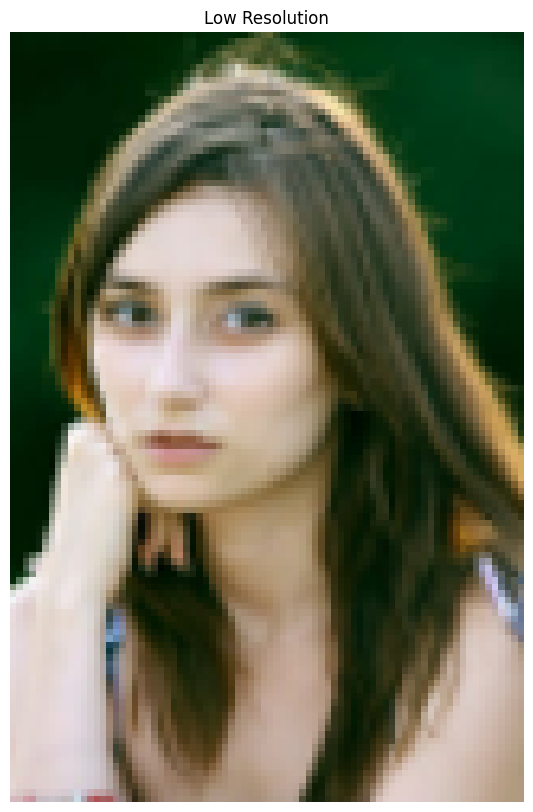

In [41]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [42]:
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)

PSNR Achieved: 28.198112


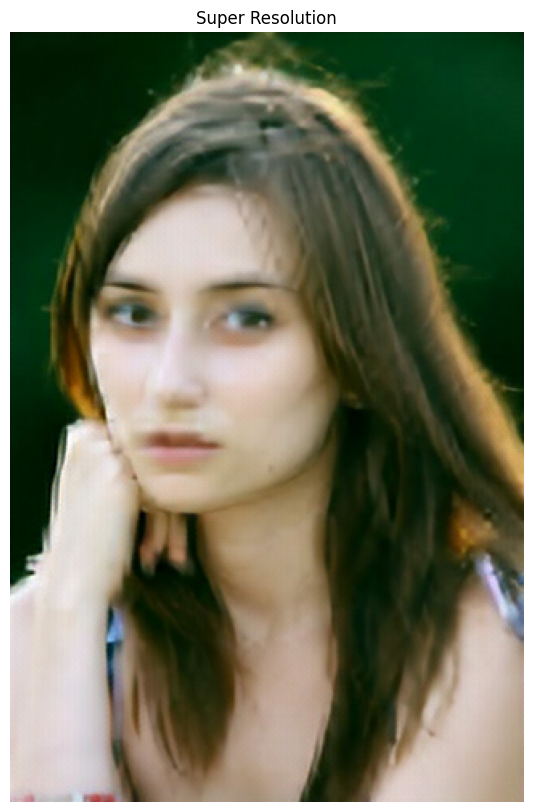

In [43]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

In [44]:
def plot_image_2(image, title=''):
    if isinstance(image, str):  # Check if image is a file path
        image = np.asarray(Image.open(image))  # Load the image from file path
    else:
        image = np.asarray(image)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

PSNR: 28.198112


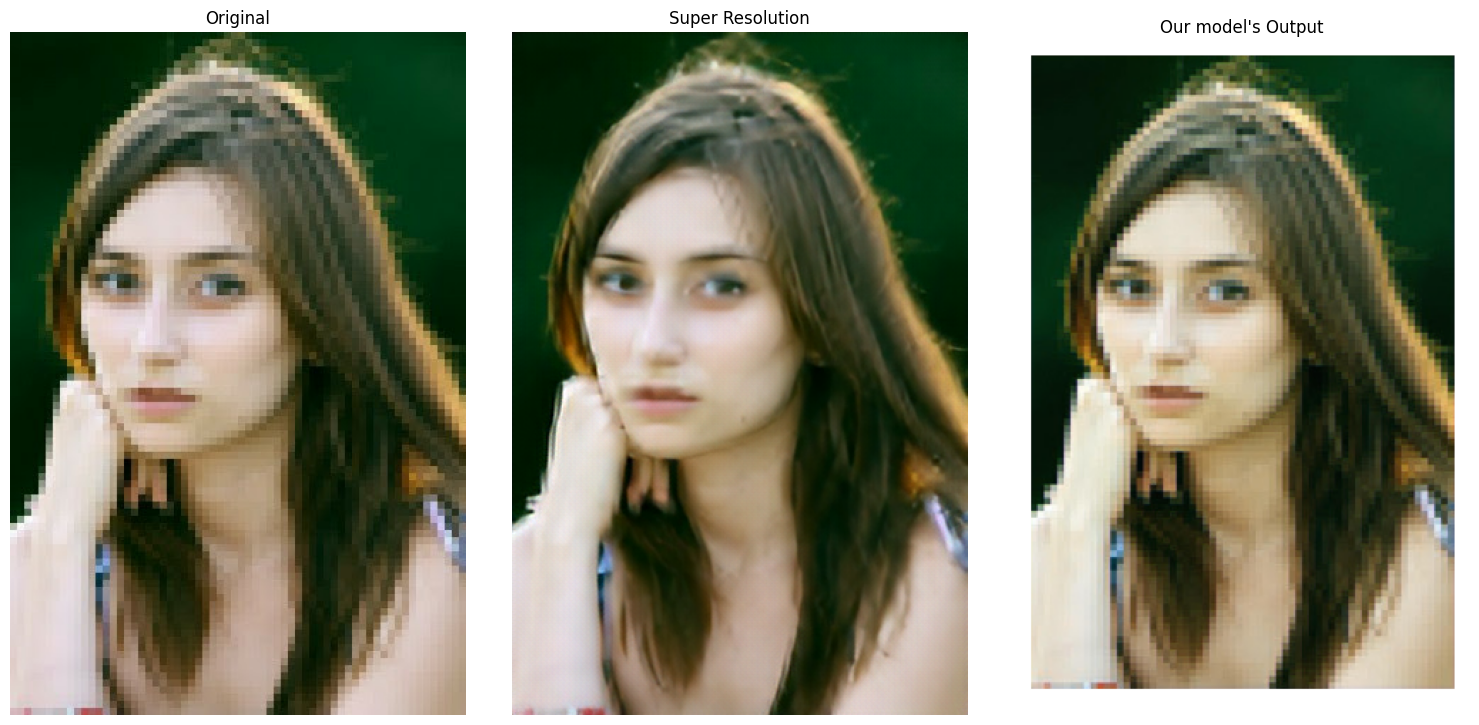

In [45]:
our_image_path = "/kaggle/input/our-model-output/our model output.png"
our_image = Image.open(our_image_path)

plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.subplot(133)
fig.tight_layout()
plot_image_2(our_image, title="Our model's Output")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)